# 人工智能基础第一次上机
## 景奕瑞-20232241467-软2304


In [ ]:
!pip install pandas matplotlib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(r'/yellow_tripdata_2015-12.csv')

In [ ]:
def readData(df):
    taxi_fields = ["VendorID", "tpep_pickup_datetime", "trip_distance", "fare_amount", "total_amount"]
    print("1. 出租车字段列表:", taxi_fields)


    field_meanings = {
        "VendorID": "供应商ID",
        "tpep_pickup_datetime": "接客时间",
        "trip_distance": "行程距离",
        "fare_amount": "车费金额",
        "total_amount": "总费用"
    }
    print("\n2. 字段含义字典:", field_meanings)

    print("\n3. 字段名称和含义:")
    for field, meaning in field_meanings.items():
        print(f"   {field}: {meaning}")

    # 4. 使用条件语句找出总费用最高的记录，并打印结果
    if 'total_amount' in df.columns:
        max_fare_index = df['total_amount'].idxmax()
        max_fare = df.loc[max_fare_index, 'total_amount']

        print(f"\n4. 最高总费用分析:")
        print(f"   最高总费用: ${max_fare:.2f}")
        print(f"   该记录索引: {max_fare_index}")

    # 显示该记录的详细信息
    if max_fare_index in df.index:
        print(f"\n   最高费用记录的详细信息:")
        # 确保我们只访问存在的列
        available_fields = [field for field in taxi_fields if field in df.columns]
        max_fare_record = df.loc[max_fare_index, available_fields]

        for field in available_fields:
            print(f"   {field_meanings[field]}: {max_fare_record[field]}")

In [ ]:
def clean_data(df):

    print("开始数据清洗...")
    original_shape = df.shape
    print(f"原始数据形状: {original_shape}")

    # 创建数据副本，避免修改原始数据
    cleaned_df = df.copy()

    # 1. 检查并处理缺失值
    print("\n1. 缺失值处理:")
    missing_data = cleaned_df.isnull().sum()
    missing_columns = missing_data[missing_data > 0]

    if len(missing_columns) > 0:
        print("发现缺失值的列:")
        for col, count in missing_columns.items():
            percentage = (count / len(cleaned_df)) * 100
            print(f"  {col}: {count} 个缺失值 ({percentage:.2f}%)")

            # 根据列类型选择填充策略
            if cleaned_df[col].dtype in ['int64', 'float64']:
                # 数值列使用中位数填充
                fill_value = cleaned_df[col].median()
                cleaned_df[col].fillna(fill_value, inplace=True)
                print(f"    使用中位数 {fill_value} 填充")
            else:
                # 非数值列使用众数填充
                if len(cleaned_df[col].mode()) > 0:
                    fill_value = cleaned_df[col].mode()[0]
                else:
                    fill_value = "Unknown"
                cleaned_df[col].fillna(fill_value, inplace=True)
                print(f"    使用众数 '{fill_value}' 填充")
    else:
        print("  没有发现缺失值")

    # 2. 处理异常值
    print("\n2. 异常值处理:")

    # 处理日期时间异常
    if 'tpep_pickup_datetime' in cleaned_df.columns and 'tpep_dropoff_datetime' in cleaned_df.columns:
        # 确保日期列为datetime类型
        cleaned_df['tpep_pickup_datetime'] = pd.to_datetime(cleaned_df['tpep_pickup_datetime'])
        cleaned_df['tpep_dropoff_datetime'] = pd.to_datetime(cleaned_df['tpep_dropoff_datetime'])

        # 计算行程时间（分钟）
        cleaned_df['trip_duration'] = (cleaned_df['tpep_dropoff_datetime'] - cleaned_df['tpep_pickup_datetime']).dt.total_seconds() / 60

        # 处理异常的行程时间
        # 1. 处理接客时间和下车时间相同的情况（行程时间为0）
        zero_duration = (cleaned_df['trip_duration'] == 0).sum()
        if zero_duration > 0:
            # 对于行程时间为0的记录，根据行程距离估算合理的时间
            # 假设平均速度为10英里/小时，则时间(分钟) = 距离(英里) / 10 * 60
            cleaned_df.loc[cleaned_df['trip_duration'] == 0, 'trip_duration'] = \
                cleaned_df.loc[cleaned_df['trip_duration'] == 0, 'trip_distance'] / 10 * 60
            print(f"  修正了 {zero_duration} 个行程时间为0的记录")

        # 2. 处理跨天的行程（例如从12月1日到12月2日）
        cross_day_trips = (cleaned_df['trip_duration'] > 24*60).sum()
        if cross_day_trips > 0:
            # 对于跨天的行程，检查是否是数据错误
            # 可能的情况是下车日期错误，我们假设行程应该在当天结束
            for idx in cleaned_df[cleaned_df['trip_duration'] > 24*60].index:
                pickup_time = cleaned_df.loc[idx, 'tpep_pickup_datetime']
                dropoff_time = cleaned_df.loc[idx, 'tpep_dropoff_datetime']

                # 如果接客和下车日期不同，但时间合理，可能是日期录入错误
                if pickup_time.date() != dropoff_time.date():
                    # 假设下车时间应该在接客时间的同一天
                    # 保持下车时间不变，但日期改为接客日期
                    same_day_dropoff = pd.Timestamp(
                        year=pickup_time.year,
                        month=pickup_time.month,
                        day=pickup_time.day,
                        hour=dropoff_time.hour,
                        minute=dropoff_time.minute,
                        second=dropoff_time.second
                    )
                    cleaned_df.loc[idx, 'tpep_dropoff_datetime'] = same_day_dropoff

            # 重新计算行程时间
            cleaned_df['trip_duration'] = (cleaned_df['tpep_dropoff_datetime'] - cleaned_df['tpep_pickup_datetime']).dt.total_seconds() / 60
            print(f"  修正了 {cross_day_trips} 个跨天行程的记录")

    # 处理行程距离异常值
    if 'trip_distance' in cleaned_df.columns:
        # 1. 处理距离为0但有费用的记录
        zero_distance_with_fare = ((cleaned_df['trip_distance'] == 0) & (cleaned_df['fare_amount'] > 0)).sum()
        if zero_distance_with_fare > 0:
            # 对于这种情况，根据车费估算合理的距离
            # 假设每英里费用为2.5美元
            cleaned_df.loc[(cleaned_df['trip_distance'] == 0) & (cleaned_df['fare_amount'] > 0), 'trip_distance'] = \
                cleaned_df.loc[(cleaned_df['trip_distance'] == 0) & (cleaned_df['fare_amount'] > 0), 'fare_amount'] / 2.5
            print(f"  修正了 {zero_distance_with_fare} 个距离为0但有车费的记录")

        # 2. 处理负值距离
        negative_distance = (cleaned_df['trip_distance'] < 0).sum()
        if negative_distance > 0:
            median_distance = cleaned_df[cleaned_df['trip_distance'] >= 0]['trip_distance'].median()
            cleaned_df.loc[cleaned_df['trip_distance'] < 0, 'trip_distance'] = median_distance
            print(f"  修正了 {negative_distance} 个负数的行程距离")

        # 3. 处理过大距离（大于100英里）
        extreme_distance = (cleaned_df['trip_distance'] > 100).sum()
        if extreme_distance > 0:
            median_distance = cleaned_df[cleaned_df['trip_distance'] <= 100]['trip_distance'].median()
            cleaned_df.loc[cleaned_df['trip_distance'] > 100, 'trip_distance'] = median_distance
            print(f"  修正了 {extreme_distance} 个过大的行程距离(>100英里)")

    # 处理经纬度异常值
    # 根据您提供的数据，有些记录的经纬度为0，这显然是异常值
    if 'pickup_longitude' in cleaned_df.columns and 'pickup_latitude' in cleaned_df.columns:
        # 处理经纬度为0的情况
        zero_pickup_long = (cleaned_df['pickup_longitude'] == 0).sum()
        zero_pickup_lat = (cleaned_df['pickup_latitude'] == 0).sum()

        if zero_pickup_long > 0 or zero_pickup_lat > 0:
            # 使用纽约市的平均经纬度填充
            nyc_avg_long = -73.98
            nyc_avg_lat = 40.75

            cleaned_df.loc[cleaned_df['pickup_longitude'] == 0, 'pickup_longitude'] = nyc_avg_long
            cleaned_df.loc[cleaned_df['pickup_latitude'] == 0, 'pickup_latitude'] = nyc_avg_lat
            print(f"  修正了 {zero_pickup_long} 个接客经度为0的记录")
            print(f"  修正了 {zero_pickup_lat} 个接客纬度为0的记录")

    if 'dropoff_longitude' in cleaned_df.columns and 'dropoff_latitude' in cleaned_df.columns:
        # 处理下车经纬度为0的情况
        zero_dropoff_long = (cleaned_df['dropoff_longitude'] == 0).sum()
        zero_dropoff_lat = (cleaned_df['dropoff_latitude'] == 0).sum()

        if zero_dropoff_long > 0 or zero_dropoff_lat > 0:
            # 使用纽约市的平均经纬度填充
            nyc_avg_long = -73.98
            nyc_avg_lat = 40.75

            cleaned_df.loc[cleaned_df['dropoff_longitude'] == 0, 'dropoff_longitude'] = nyc_avg_long
            cleaned_df.loc[cleaned_df['dropoff_latitude'] == 0, 'dropoff_latitude'] = nyc_avg_lat
            print(f"  修正了 {zero_dropoff_long} 个下车经度为0的记录")
            print(f"  修正了 {zero_dropoff_lat} 个下车纬度为0的记录")

    # 处理费用异常值
    if 'fare_amount' in cleaned_df.columns:
        # 处理负值车费
        negative_fare = (cleaned_df['fare_amount'] < 0).sum()
        if negative_fare > 0:
            median_fare = cleaned_df[cleaned_df['fare_amount'] >= 0]['fare_amount'].median()
            cleaned_df.loc[cleaned_df['fare_amount'] < 0, 'fare_amount'] = median_fare
            print(f"  修正了 {negative_fare} 个负数的车费金额")

        # 处理过大车费（大于500美元）
        extreme_fare = (cleaned_df['fare_amount'] > 500).sum()
        if extreme_fare > 0:
            median_fare = cleaned_df[cleaned_df['fare_amount'] <= 500]['fare_amount'].median()
            cleaned_df.loc[cleaned_df['fare_amount'] > 500, 'fare_amount'] = median_fare
            print(f"  修正了 {extreme_fare} 个过大的车费金额(>$500)")

    if 'total_amount' in cleaned_df.columns:
        # 处理负值总费用
        negative_total = (cleaned_df['total_amount'] < 0).sum()
        if negative_total > 0:
            median_total = cleaned_df[cleaned_df['total_amount'] >= 0]['total_amount'].median()
            cleaned_df.loc[cleaned_df['total_amount'] < 0, 'total_amount'] = median_total
            print(f"  修正了 {negative_total} 个负数的总费用")

        # 处理过大总费用（大于1000美元）
        extreme_total = (cleaned_df['total_amount'] > 1000).sum()
        if extreme_total > 0:
            median_total = cleaned_df[cleaned_df['total_amount'] <= 1000]['total_amount'].median()
            cleaned_df.loc[cleaned_df['total_amount'] > 1000, 'total_amount'] = median_total
            print(f"  修正了 {extreme_total} 个过大的总费用(>$1000)")

    # 处理乘客数量异常值
    if 'passenger_count' in cleaned_df.columns:
        invalid_passengers = ((cleaned_df['passenger_count'] < 1) | (cleaned_df['passenger_count'] > 6)).sum()
        if invalid_passengers > 0:
            cleaned_df.loc[(cleaned_df['passenger_count'] < 1) | (cleaned_df['passenger_count'] > 6), 'passenger_count'] = 1
            print(f"  修正了 {invalid_passengers} 个无效的乘客数量")

    # 3. 数据转换和特征工程
    print("\n3. 数据转换和特征工程:")

    # 创建新的时间特征
    if 'tpep_pickup_datetime' in cleaned_df.columns:
        cleaned_df['pickup_hour'] = cleaned_df['tpep_pickup_datetime'].dt.hour
        cleaned_df['pickup_dayofweek'] = cleaned_df['tpep_pickup_datetime'].dt.dayofweek
        cleaned_df['pickup_month'] = cleaned_df['tpep_pickup_datetime'].dt.month
        print("  已创建时间特征: pickup_hour, pickup_dayofweek, pickup_month")

    # 计算平均速度（英里/小时）
    if all(col in cleaned_df.columns for col in ['trip_distance', 'trip_duration']):
        cleaned_df['avg_speed_mph'] = cleaned_df['trip_distance'] / (cleaned_df['trip_duration'] / 60)

        # 处理异常速度
        invalid_speed = ((cleaned_df['avg_speed_mph'] < 1) | (cleaned_df['avg_speed_mph'] > 100)).sum()
        if invalid_speed > 0:
            median_speed = cleaned_df[
                (cleaned_df['avg_speed_mph'] >= 1) & (cleaned_df['avg_speed_mph'] <= 100)
            ]['avg_speed_mph'].median()
            cleaned_df.loc[
                (cleaned_df['avg_speed_mph'] < 1) | (cleaned_df['avg_speed_mph'] > 100),
                'avg_speed_mph'
            ] = median_speed
            print(f"  修正了 {invalid_speed} 个异常的平均速度")

    # 创建行程类型分类
    if 'trip_distance' in cleaned_df.columns:
        conditions = [
            cleaned_df['trip_distance'] < 1,
            (cleaned_df['trip_distance'] >= 1) & (cleaned_df['trip_distance'] < 3),
            (cleaned_df['trip_distance'] >= 3) & (cleaned_df['trip_distance'] < 10),
            cleaned_df['trip_distance'] >= 10
        ]
        choices = ['短途', '中途', '长途', '超长途']
        cleaned_df['trip_type'] = np.select(conditions, choices, default='中途')
        print("  已创建行程类型分类")

    print(f"\n清洗后数据形状: {cleaned_df.shape}")
    print(f"清洗后缺失值数量: {cleaned_df.isnull().sum().sum()}")
    print("数据清洗完成!")

    return cleaned_df

# 调用清洗函数
print("调用clean_data函数进行数据预处理...")
cleaned_df = clean_data(df)

# 打印清洗后的前10行数据
print(f"\n清洗后的数据前10行:")
pd.set_option('display.max_columns', None)  # 显示所有列
print(cleaned_df.head(10))
pd.reset_option('display.max_columns')  # 重置显示选项

# 显示清洗效果对比
print(f"\n清洗效果对比:")
print(f"原始数据形状: {df.shape}")
print(f"清洗后数据形状: {cleaned_df.shape}")

# 显示异常值处理情况
print(f"\n异常值处理情况:")
if 'trip_duration' in cleaned_df.columns:
    print(f"行程时间范围: {cleaned_df['trip_duration'].min():.2f} - {cleaned_df['trip_duration'].max():.2f} 分钟")

if 'trip_distance' in cleaned_df.columns:
    print(f"行程距离范围: {cleaned_df['trip_distance'].min():.2f} - {cleaned_df['trip_distance'].max():.2f} 英里")

if 'fare_amount' in cleaned_df.columns:
    print(f"车费金额范围: ${cleaned_df['fare_amount'].min():.2f} - ${cleaned_df['fare_amount'].max():.2f}")

if 'total_amount' in cleaned_df.columns:
    print(f"总费用范围: ${cleaned_df['total_amount'].min():.2f} - ${cleaned_df['total_amount'].max():.2f}")

In [47]:
def analyze_distribution_and_trends(cleaned_df):

    print("开始数据分布和趋势分析...")
    results = {}

    # 1. 绘制行程距离和车费金额的直方图
    print("\n" + "="*50)
    print("1. 数据分布分析 - 直方图")
    print("="*50)

    plt.figure(figsize=(14, 6))

    # 行程距离直方图
    plt.subplot(1, 2, 1)
    if 'trip_distance' in cleaned_df.columns:
        # 过滤掉极端值以便更好地观察分布
        distance_data = cleaned_df[cleaned_df['trip_distance'] <= cleaned_df['trip_distance'].quantile(0.95)]['trip_distance']
        plt.hist(distance_data, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.xlabel('行程距离 (英里)')
        plt.ylabel('频次')
        plt.title('行程距离分布')

        # 添加统计信息
        mean_distance = cleaned_df['trip_distance'].mean()
        median_distance = cleaned_df['trip_distance'].median()
        plt.axvline(mean_distance, color='red', linestyle='--', linewidth=2, label=f'均值: {mean_distance:.2f}英里')
        plt.axvline(median_distance, color='green', linestyle='--', linewidth=2, label=f'中位数: {median_distance:.2f}英里')
        plt.legend()
        plt.grid(True, alpha=0.3)

        results['distance_stats'] = {
            'mean': mean_distance,
            'median': median_distance,
            'max': cleaned_df['trip_distance'].max(),
            'min': cleaned_df['trip_distance'].min()
        }
    else:
        plt.text(0.5, 0.5, '无行程距离数据', ha='center', va='center', transform=plt.gca().transAxes)

    # 车费金额直方图
    plt.subplot(1, 2, 2)
    if 'fare_amount' in cleaned_df.columns:
        # 过滤掉极端值以便更好地观察分布
        fare_data = cleaned_df[cleaned_df['fare_amount'] <= cleaned_df['fare_amount'].quantile(0.95)]['fare_amount']
        plt.hist(fare_data, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
        plt.xlabel('车费金额 ($)')
        plt.ylabel('频次')
        plt.title('车费金额分布')

        # 添加统计信息
        mean_fare = cleaned_df['fare_amount'].mean()
        median_fare = cleaned_df['fare_amount'].median()
        plt.axvline(mean_fare, color='red', linestyle='--', linewidth=2, label=f'均值: ${mean_fare:.2f}')
        plt.axvline(median_fare, color='green', linestyle='--', linewidth=2, label=f'中位数: ${median_fare:.2f}')
        plt.legend()
        plt.grid(True, alpha=0.3)

        results['fare_stats'] = {
            'mean': mean_fare,
            'median': median_fare,
            'max': cleaned_df['fare_amount'].max(),
            'min': cleaned_df['fare_amount'].min()
        }
    else:
        plt.text(0.5, 0.5, '无车费金额数据', ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    # 2. 计算并绘制每日变化趋势
    print("\n" + "="*50)
    print("2. 周期性分析 - 每日变化趋势")
    print("="*50)

    if 'tpep_pickup_datetime' in cleaned_df.columns:
        # 确保日期列为datetime类型
        if not pd.api.types.is_datetime64_any_dtype(cleaned_df['tpep_pickup_datetime']):
            cleaned_df['tpep_pickup_datetime'] = pd.to_datetime(cleaned_df['tpep_pickup_datetime'])

        # 提取日期信息
        cleaned_df['pickup_date'] = cleaned_df['tpep_pickup_datetime'].dt.date

        # 按日期聚合数据
        daily_metrics = cleaned_df.groupby('pickup_date').agg({
            'trip_distance': 'mean' if 'trip_distance' in cleaned_df.columns else None,
            'fare_amount': 'mean' if 'fare_amount' in cleaned_df.columns else None,
            'total_amount': 'mean' if 'total_amount' in cleaned_df.columns else None,
            'VendorID': 'count' if 'VendorID' in cleaned_df.columns else None
        }).round(3)

        # 重命名列
        new_names = {}
        if 'trip_distance' in daily_metrics.columns:
            new_names['trip_distance'] = '平均行程距离'
        if 'fare_amount' in daily_metrics.columns:
            new_names['fare_amount'] = '平均车费金额'
        if 'total_amount' in daily_metrics.columns:
            new_names['total_amount'] = '平均总费用'
        if 'VendorID' in daily_metrics.columns:
            new_names['VendorID'] = '行程数量'

        daily_metrics = daily_metrics.rename(columns=new_names)
        results['daily_metrics'] = daily_metrics

        print("每日指标摘要:")
        print(daily_metrics.head(10))

        # 绘制每日变化趋势图
        plt.figure(figsize=(15, 10))

        # 平均行程距离趋势
        if '平均行程距离' in daily_metrics.columns:
            plt.subplot(2, 2, 1)
            plt.plot(daily_metrics.index, daily_metrics['平均行程距离'],
                    marker='o', linewidth=2, markersize=4, color='blue', alpha=0.7)
            plt.xlabel('日期')
            plt.ylabel('平均行程距离 (英里)')
            plt.title('每日平均行程距离变化趋势')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)

            # 添加趋势线
            if len(daily_metrics) > 1:
                x_numeric = np.arange(len(daily_metrics))
                z = np.polyfit(x_numeric, daily_metrics['平均行程距离'], 1)
                p = np.poly1d(z)
                plt.plot(daily_metrics.index, p(x_numeric), "r--", alpha=0.8, linewidth=2,
                        label=f'趋势线: y={z[0]:.4f}x+{z[1]:.2f}')
                plt.legend()

        # 平均车费金额趋势
        if '平均车费金额' in daily_metrics.columns:
            plt.subplot(2, 2, 2)
            plt.plot(daily_metrics.index, daily_metrics['平均车费金额'],
                    marker='s', linewidth=2, markersize=4, color='red', alpha=0.7)
            plt.xlabel('日期')
            plt.ylabel('平均车费金额 ($)')
            plt.title('每日平均车费金额变化趋势')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)

            # 添加趋势线
            if len(daily_metrics) > 1:
                x_numeric = np.arange(len(daily_metrics))
                z = np.polyfit(x_numeric, daily_metrics['平均车费金额'], 1)
                p = np.poly1d(z)
                plt.plot(daily_metrics.index, p(x_numeric), "r--", alpha=0.8, linewidth=2,
                        label=f'趋势线: y={z[0]:.4f}x+{z[1]:.2f}')
                plt.legend()

        # 行程数量趋势
        if '行程数量' in daily_metrics.columns:
            plt.subplot(2, 2, 3)
            plt.bar(daily_metrics.index, daily_metrics['行程数量'],
                   color='green', alpha=0.7)
            plt.xlabel('日期')
            plt.ylabel('行程数量')
            plt.title('每日行程数量变化')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)

        # 平均总费用趋势
        if '平均总费用' in daily_metrics.columns:
            plt.subplot(2, 2, 4)
            plt.plot(daily_metrics.index, daily_metrics['平均总费用'],
                    marker='^', linewidth=2, markersize=4, color='purple', alpha=0.7)
            plt.xlabel('日期')
            plt.ylabel('平均总费用 ($)')
            plt.title('每日平均总费用变化趋势')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)

            # 添加趋势线
            if len(daily_metrics) > 1:
                x_numeric = np.arange(len(daily_metrics))
                z = np.polyfit(x_numeric, daily_metrics['平均总费用'], 1)
                p = np.poly1d(z)
                plt.plot(daily_metrics.index, p(x_numeric), "r--", alpha=0.8, linewidth=2,
                        label=f'趋势线: y={z[0]:.4f}x+{z[1]:.2f}')
                plt.legend()

        plt.tight_layout()
        plt.show()

        # 3. 计算相关性并绘制散点图
        print("\n" + "="*50)
        print("3. 行程距离与车费金额关系分析")
        print("="*50)

        if 'trip_distance' in cleaned_df.columns and 'fare_amount' in cleaned_df.columns:
            # 计算相关系数
            correlation = cleaned_df['trip_distance'].corr(cleaned_df['fare_amount'])
            results['distance_fare_correlation'] = correlation

            print(f"行程距离与车费金额的相关系数: {correlation:.3f}")

            if correlation > 0.7:
                strength = "强正相关"
            elif correlation > 0.3:
                strength = "中等正相关"
            elif correlation > 0:
                strength = "弱正相关"
            elif correlation == 0:
                strength = "无相关"
            elif correlation > -0.3:
                strength = "弱负相关"
            elif correlation > -0.7:
                strength = "中等负相关"
            else:
                strength = "强负相关"

            print(f"相关性强度: {strength}")

            # 绘制散点图
            plt.figure(figsize=(10, 6))

            # 过滤掉极端值以便更好地观察关系
            filtered_df = cleaned_df[
                (cleaned_df['trip_distance'] <= cleaned_df['trip_distance'].quantile(0.95)) &
                (cleaned_df['fare_amount'] <= cleaned_df['fare_amount'].quantile(0.95))
            ]

            plt.scatter(filtered_df['trip_distance'], filtered_df['fare_amount'],
                       alpha=0.5, s=20, color='blue')
            plt.xlabel('行程距离 (英里)')
            plt.ylabel('车费金额 ($)')
            plt.title(f'行程距离 vs 车费金额 (相关系数: {correlation:.3f})')
            plt.grid(True, alpha=0.3)

            # 添加趋势线
            if len(filtered_df) > 1:
                z = np.polyfit(filtered_df['trip_distance'], filtered_df['fare_amount'], 1)
                p = np.poly1d(z)
                x_range = np.linspace(filtered_df['trip_distance'].min(), filtered_df['trip_distance'].max(), 100)
                plt.plot(x_range, p(x_range), "r-", linewidth=2,
                        label=f'趋势线: y={z[0]:.2f}x+{z[1]:.2f}')
                plt.legend()

            plt.tight_layout()
            plt.show()
        else:
            print("缺少行程距离或车费金额数据，无法进行关系分析")
    else:
        print("数据中缺少日期时间信息，无法进行周期性分析")

    print("\n数据分布和趋势分析完成!")
    return results

# 调用函数进行分析
print("调用analyze_distribution_and_trends函数进行分析...")
analysis_results = analyze_distribution_and_trends(cleaned_df)

# 显示关键结果摘要
print("\n" + "="*50)
print("关键结果摘要")
print("="*50)

if 'distance_stats' in analysis_results:
    stats = analysis_results['distance_stats']
    print("行程距离统计:")
    print(f"  平均值: {stats['mean']:.2f} 英里")
    print(f"  中位数: {stats['median']:.2f} 英里")
    print(f"  最大值: {stats['max']:.2f} 英里")
    print(f"  最小值: {stats['min']:.2f} 英里")

if 'fare_stats' in analysis_results:
    stats = analysis_results['fare_stats']
    print("\n车费金额统计:")
    print(f"  平均值: ${stats['mean']:.2f}")
    print(f"  中位数: ${stats['median']:.2f}")
    print(f"  最大值: ${stats['max']:.2f}")
    print(f"  最小值: ${stats['min']:.2f}")

if 'distance_fare_correlation' in analysis_results:
    corr = analysis_results['distance_fare_correlation']
    print(f"\n行程距离与车费金额相关性: {corr:.3f}")

    # 解释相关性
    if corr > 0.7:
        interpretation = "行程距离与车费金额呈强正相关，距离越长，车费越高"
    elif corr > 0.3:
        interpretation = "行程距离与车费金额呈中等正相关，距离对车费有显著影响"
    elif corr > 0:
        interpretation = "行程距离与车费金额呈弱正相关，距离对车费有一定影响"
    elif corr == 0:
        interpretation = "行程距离与车费金额无明显相关"
    elif corr > -0.3:
        interpretation = "行程距离与车费金额呈弱负相关"
    elif corr > -0.7:
        interpretation = "行程距离与车费金额呈中等负相关"
    else:
        interpretation = "行程距离与车费金额呈强负相关"

    print(f"  解释: {interpretation}")


KeyboardInterrupt



1. 出租车字段列表: ['VendorID', 'tpep_pickup_datetime', 'trip_distance', 'fare_amount', 'total_amount']

2. 字段含义字典: {'VendorID': '供应商ID', 'tpep_pickup_datetime': '接客时间', 'trip_distance': '行程距离', 'fare_amount': '车费金额', 'total_amount': '总费用'}

3. 字段名称和含义:
   VendorID: 供应商ID
   tpep_pickup_datetime: 接客时间
   trip_distance: 行程距离
   fare_amount: 车费金额
   total_amount: 总费用

4. 最高总费用分析:
   最高总费用: $826039.97
   该记录索引: 9959620

   最高费用记录的详细信息:
   供应商ID: 1
   接客时间: 2015-12-27 03:44:25
   行程距离: 0.0
   车费金额: 825998.61
   总费用: 826039.97
开始数据清洗...
原始数据形状: (11460573, 19)

1. 缺失值处理:
  没有发现缺失值

2. 异常值处理:
  修正了 12946 个行程时间为0的记录
  修正了 4 个跨天行程的记录
  修正了 70895 个距离为0但有车费的记录
  修正了 390 个过大的行程距离(>100英里)
  修正了 167117 个接客经度为0的记录
  修正了 167117 个接客纬度为0的记录
  修正了 158173 个下车经度为0的记录
  修正了 158173 个下车纬度为0的记录
  修正了 4458 个负数的车费金额
  修正了 44 个过大的车费金额(>$500)
  修正了 4459 个负数的总费用
  修正了 18 个过大的总费用(>$1000)
  修正了 574 个无效的乘客数量

3. 数据转换和特征工程:
  已创建时间特征: pickup_hour, pickup_dayofweek, pickup_month
  修正了 92450 个异常的平均速度
  已创建行程类型分类

清洗后数据形状: (1146

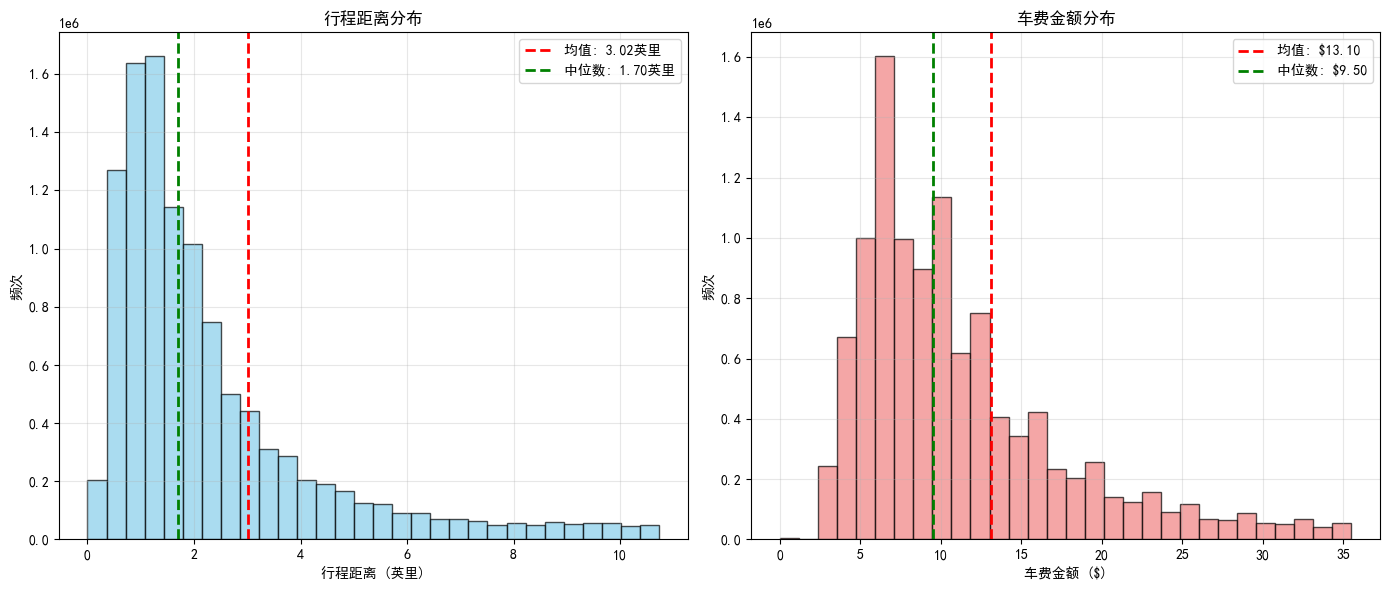


2. 周期性分析 - 每日变化趋势
每日指标摘要:
             平均行程距离  平均车费金额   平均总费用    行程数量
pickup_date                                
2015-12-01    2.954  13.393  16.778  374390
2015-12-02    2.995  13.458  16.909  379756
2015-12-03    3.045  13.683  17.156  414005
2015-12-04    3.030  13.473  16.870  431007
2015-12-05    2.822  12.515  15.305  451092
2015-12-06    3.247  13.024  16.110  398882
2015-12-07    3.107  13.234  16.668  371715
2015-12-08    2.965  13.542  17.015  382226
2015-12-09    3.017  13.833  17.375  391440
2015-12-10    3.083  14.070  17.654  406176


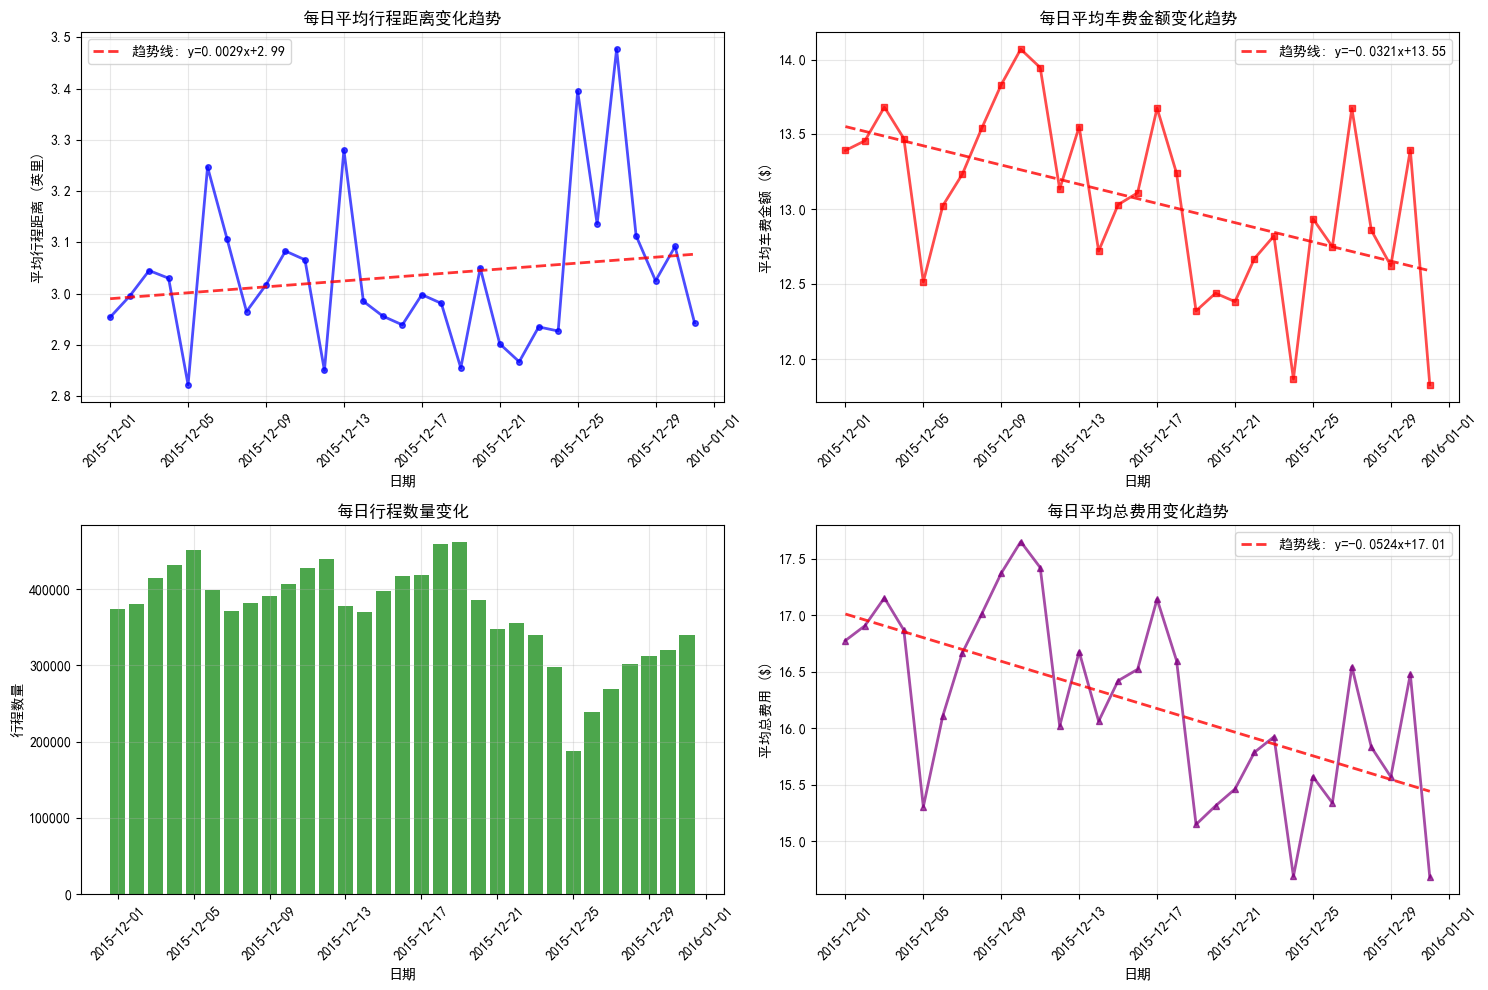


3. 行程距离与车费金额关系分析
行程距离与车费金额的相关系数: 0.928
相关性强度: 强正相关


C:\Users\Jw\AppData\Local\Temp\ipykernel_32756\2940458226.py:246: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
D:\ANACONDA\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


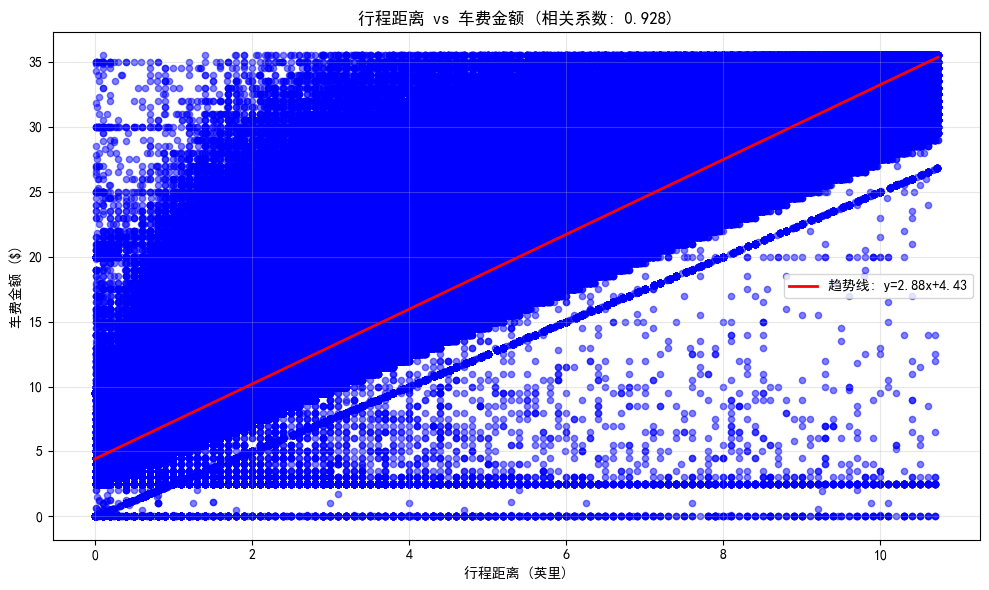


数据分布和趋势分析完成!


{'distance_stats': {'mean': np.float64(3.019272962529881),
  'median': 1.7,
  'max': 100.0,
  'min': 0.0},
 'fare_stats': {'mean': np.float64(13.095518953546225),
  'median': 9.5,
  'max': 500.0,
  'min': 0.0},
 'daily_metrics':              平均行程距离  平均车费金额   平均总费用    行程数量
 pickup_date                                
 2015-12-01    2.954  13.393  16.778  374390
 2015-12-02    2.995  13.458  16.909  379756
 2015-12-03    3.045  13.683  17.156  414005
 2015-12-04    3.030  13.473  16.870  431007
 2015-12-05    2.822  12.515  15.305  451092
 2015-12-06    3.247  13.024  16.110  398882
 2015-12-07    3.107  13.234  16.668  371715
 2015-12-08    2.965  13.542  17.015  382226
 2015-12-09    3.017  13.833  17.375  391440
 2015-12-10    3.083  14.070  17.654  406176
 2015-12-11    3.066  13.947  17.425  427829
 2015-12-12    2.850  13.135  16.020  439266
 2015-12-13    3.280  13.552  16.679  377073
 2015-12-14    2.985  12.721  16.063  370299
 2015-12-15    2.956  13.031  16.422  396958
 2015-1

In [48]:
readData(df)
cleaned_df=clean_data(df)
analyze_distribution_and_trends(cleaned_df)